In [1]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import pandas as pd


In [2]:
# load the model
import tensorflow as tf
from tensorflow import keras
import numpy as np

new_model = keras.models.load_model('cnn_lstm_original_model.keras')

c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 1, 98, 64)      │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1, 49, 64)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 1, 47, 128)     │        24,704 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 1, 23, 128)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 1, 21, 64)      │        24,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 1, 10, 64)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 1, 640)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 200)         │       592,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,766,804 (6.74 MB)

 Trainable params: 883,401 (3.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 883,403 (3.37 MB)

In [4]:
# For data preprocessing and analysis part

from sklearn.model_selection import train_test_split


data2 = pd.read_csv('../Datasets/MSFT.csv')
# Any CSV or TXT file can be added here....
data2.dropna(inplace=True)
data2.head()

data2.reset_index(drop=True, inplace=True)
# data2.fillna(data.mean(), inplace=True)
# data2.head()

numeric_columns = data2.select_dtypes(include=['float64', 'int64']).columns
data2[numeric_columns] = data2[numeric_columns].fillna(data2[numeric_columns].mean())
data2.head()

df2 = data2.drop('Date', axis=1)

print(df2)

X = []
Y = []
window_size=100
for i in range(1 , len(df2) - window_size -1 , 1):
    first = df2.iloc[i,4]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df2.iloc[i + j, 4] - first) / first)
    # for j in range(week):
    temp2.append((df2.iloc[i + window_size, 4] - first) / first)
    # X.append(np.array(stock.iloc[i:i+window_size,4]).reshape(50,1))
    # Y.append(np.array(stock.iloc[i+window_size,4]).reshape(1,1))
    # print(stock2.iloc[i:i+window_size,4])
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

         Open    High       Low   Close    Volume
0      37.350   37.40   37.1000   37.16  30632200
1      37.200   37.22   36.6000   36.91  31134800
2      36.850   36.89   36.1100   36.13  43603700
3      36.325   36.49   36.2100   36.41  35802800
4      36.000   36.14   35.5800   35.76  59971700
...       ...     ...       ...     ...       ...
2532  404.320  407.01  402.5294  404.87  21021155
2533  404.370  406.17  402.4300  403.93  17803271
2534  406.060  409.98  404.3300  409.72  24510236
2535  412.260  413.05  406.4501  408.59  33477610
2536  406.960  415.32  397.2100  397.58  47871097

[2537 rows x 5 columns]
1948
487


In [5]:
new_model.evaluate(test_X, test_Y)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1957 - mae: 0.3378 - mse: 0.1957


[0.21511976420879364, 0.21511976420879364, 0.3459673225879669]

In [6]:
predicted  = new_model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data2.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


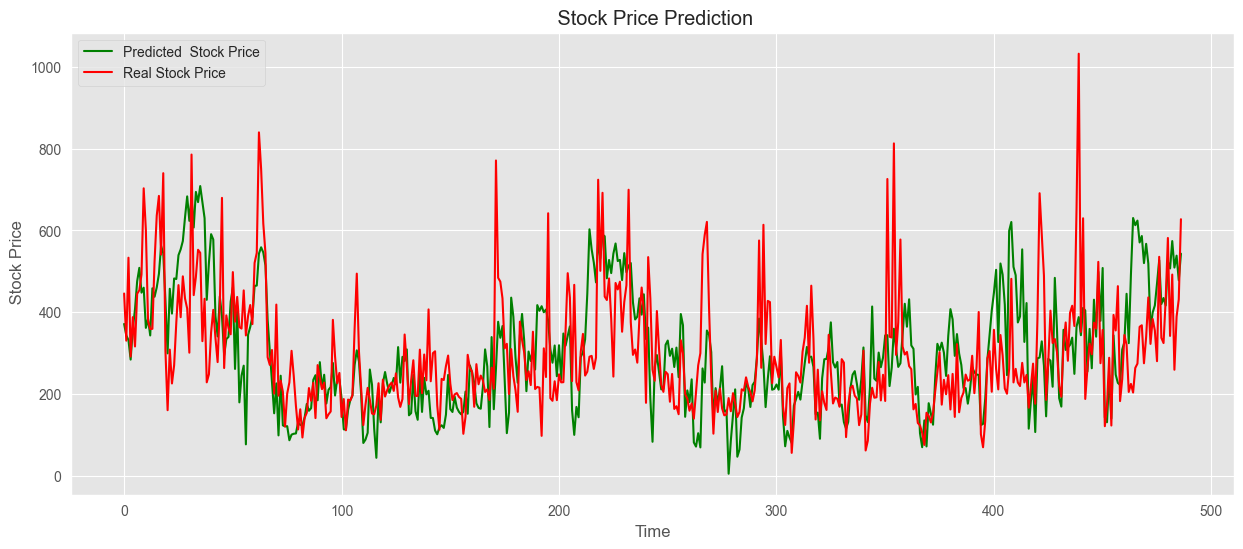

In [7]:

plt.figure(figsize=(15,6))
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = new_model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.003465
R2 Score: 0.003465
Max Error: 1031.468380
